# Hyperbolic discounting

Time preference parameters in structural models of dynamic discrete choices are underidentified, which is especially problematic for counterfactual analysis, since information on time preferences are needed to make any statement about the behavioral response of the agents to a policy intervention. 

In the literature, both theoretical arguments for identification and empirical identification strategies exploit variables that leave the per-period utility function unaffected, while being relevant to the agents' decisions. The intuition is that comparing the behavioral response of similar agents to different (expected) futures may reveal information on their time preferences.

Here we explore the practical identification of the time preference parameters in a discrete choice dynamic model of occupational choice with (quasi-)hyperbolic discounting and naïve agents, after introducing empirically-motivated exclusion restrictions that influence the size of the agents' choice set.

In [10]:
import yaml
import pickle

import pandas as pd
import respy as rp

from auxiliary import compare_choice_probabilities
from auxiliary import plot_heatmap3d
from auxiliary import get_custom_cmap
from auxiliary import plot_counterfactual_predictions

import seaborn as sns
sns.set_context("notebook", font_scale=1.5)
sns.set_style("white")

## Model



The basic set-up follows Keand and Wolpin (1994). In each period $t$, identical agents choose among four mutually
exclusive alternatives: Work in either occupation A or occupation B, continue education, or
remain at home. The departures from this model are the following:

**Agents are completely naïve (quasi-)hyperbolic discounters**. Their time preferences are described by the
discount factor $\delta$ and the present bias $\beta$ (the naïvete parameter $\tilde{\beta}$ is assumed to be 1). 

**Agents may face a restricted choice set**, depending on the exogeneous "restriction regime" they face.

- Unrestricted agents can choose any alternative in any period,
- Restricted agents need at least 12 years of education to choose occupation B,
- Very restricted agents need at least 12 and 14 years of education to choose occupation A or occupation B, respectively.
    
Therefore, while the assignment to the restriction regime is exogeneous, whether the agent actually experience employment restrictions depends deterministically on their educational choices.

## Identification strategy

Experiencing a restriction on one or more occupational choices does not enter the instantaneous
utility function from choosing to stay in school, but it raises the option value of education and
therefore its expected discounted stream of utility. The degree to which agents adjust their educational
decision should be informative of their time preferences.

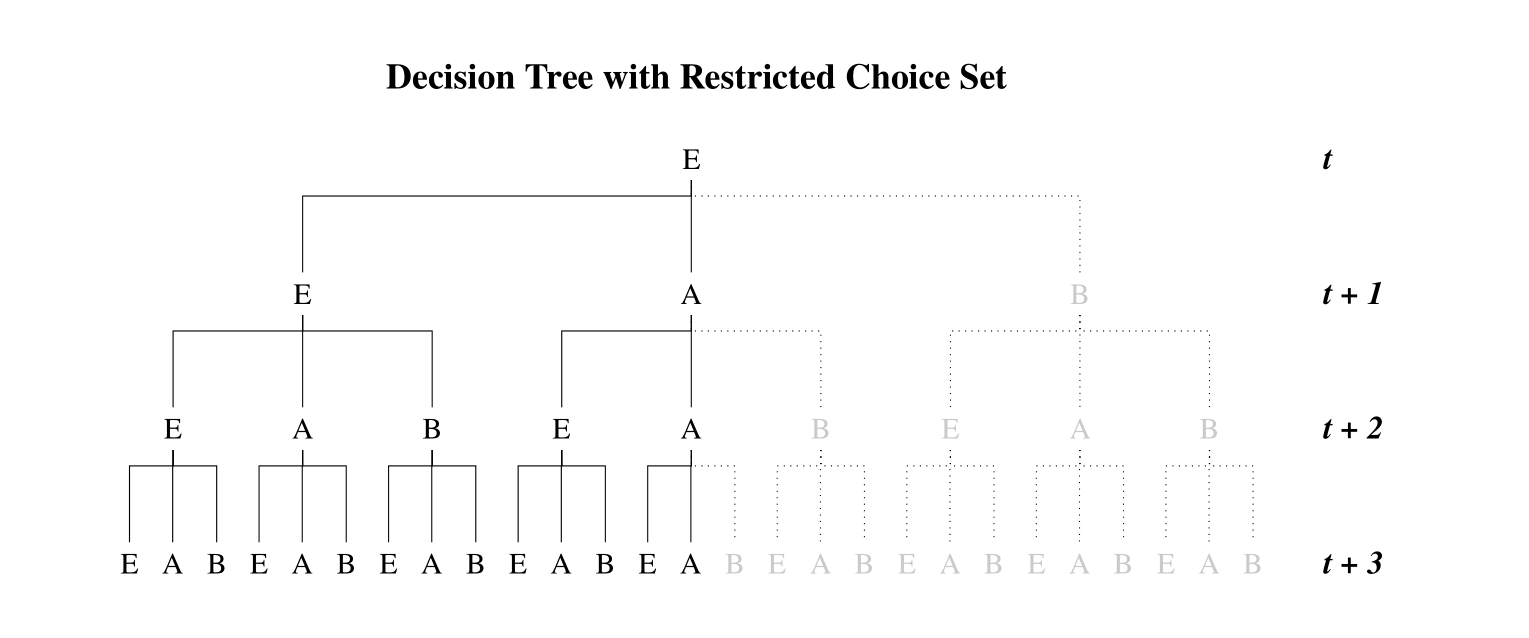

***Notes***: *Effect on the choice set of a choice restriction, if the agent has 13 period of experience in education in t.
For simplicity, the home alternative is removed. Choosing the education alternative in any period t + n allows the
agent to choose occupation B starting from period t + n + 1. An unrestricted agent can choose any alternative in
any period.*

## Simulating the data

The "observed" data are two datasets with 10,000 agents observed for 40 periods.

In [2]:
# load params
params = pd.read_csv("specs/params_hyp.csv", sep=";", index_col=["category", "name"])
params["value"] = params["value"].astype(float)

# load options
with open("specs/options_hyp.yaml") as options:
    options = yaml.safe_load(options)

# change seeds to simulated "observed" data
options["solution_seed"] = 0
options["simulation_seed"] = 1000

In [3]:
simulate = rp.get_simulate_func(params, options)
df = simulate(params)

## Visualizing the data

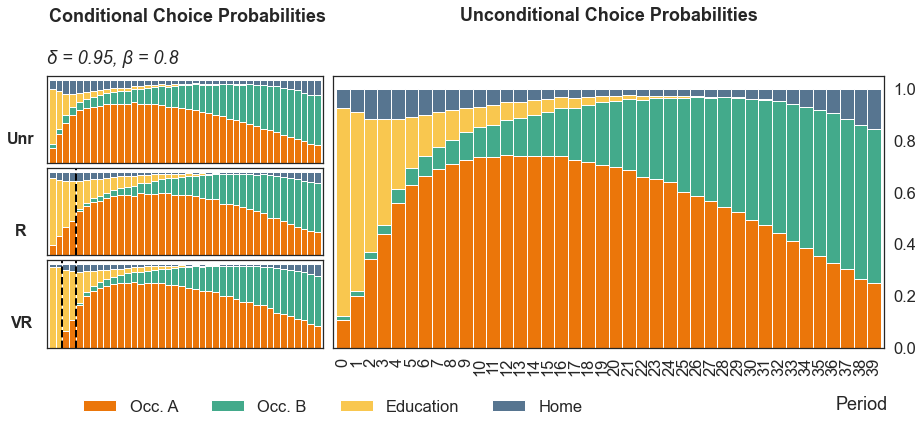

In [4]:
fig = compare_choice_probabilities(df=df)

***Notes***: *Model of occupational choice based on Keane and Wolpin (1994), one dataset with 1,000 simulated agents
and 40 observed periods. The figure shows choice probabilities conditional for unrestricted agents (**Unr**), restricted
agents who face one restroction on occupation B (**R**) and very restricted agents who face one restriction on A and
one on B (**VR**). In **R**, the dashed line indicates the first period in which agents can potentially choose occupation
B, as the initial conditions of the model ensures that all agents start with 10 years of education. In **VR**, the dashed
lines indicate the first period in which agents can potentially choose occupation A and occupation B, after 12 and
14 years of education respectively.*

At the beginning of the life-cycle the choice is among education, home, and occupation A, since occupation B provides large returns only when agents have accumulated experience in education and/or occupation A. The utility from education is low, and it becomes negative if agents go to college. Hyperbolic discounters choose the home alternative more often than exponential discounters: A lower present bias makes education less attractive, as future gains are discounted more heavily. 

Agents who face one or two restrictions tend to stay in education longer than those who don’t, as **choice restrictions increase the option value of education**:

- The exponential discounters who face restrictions stay longer in education and delay their entrance in the job market, while the share of agents shifting to the home alternative (which mostly happens at the end of the life-cycle) is nearly unchanged. 

- The hyperbolic discounters who face restrictions similarly delay their entry in the job market. However, the share of those who choose the home alternative in the initial periods decreases. This is consistent with the intuition that hyperbolic discounter are more sensitive to educational incentives, because they stay in education shorter than optimal in the first place.

## Practical identification

In practice, whether the time preference parameter(s) can be identified from the data depends
on the **curvature of the criterion function**. Consider the problem of estimating a model with exponential discounting on observational data: If the criterion is computed as a function of $\delta$ only, while all the other parameters are set a their respective estimates, we need the criterion to exhibit a unique minimum (or maximum) between 0 and 1 to recover $\delta$.

In this exercise, the Method of Simulated Moments (McFadden, 1989) criterion function is computed as a function of $\beta$ and $\delta$ only, making the optimization problem two-dimensional. The other parameters are set at their true, rather than estimated, values. This overcomes the hurdles of the real estimation process, simplifies the exposition and aids the visualization of the results. However, it represents a "best case scenario" where practical identification is not complicated by inaccurate estimates of the other model parameters.

The moments used for estimation are per-period choice probabilities, conditional on restriction regime, and the per-period wage profile (mean and standard deviation) of those who work, again conditional on restriction regime. The weighting matrix is a diagonal matrix where the weights are the inverse variances of the observed sample moments, computed via a bootstrapping procedure.

In [5]:
df_heatmap = pd.read_csv("data/heatmap.csv")

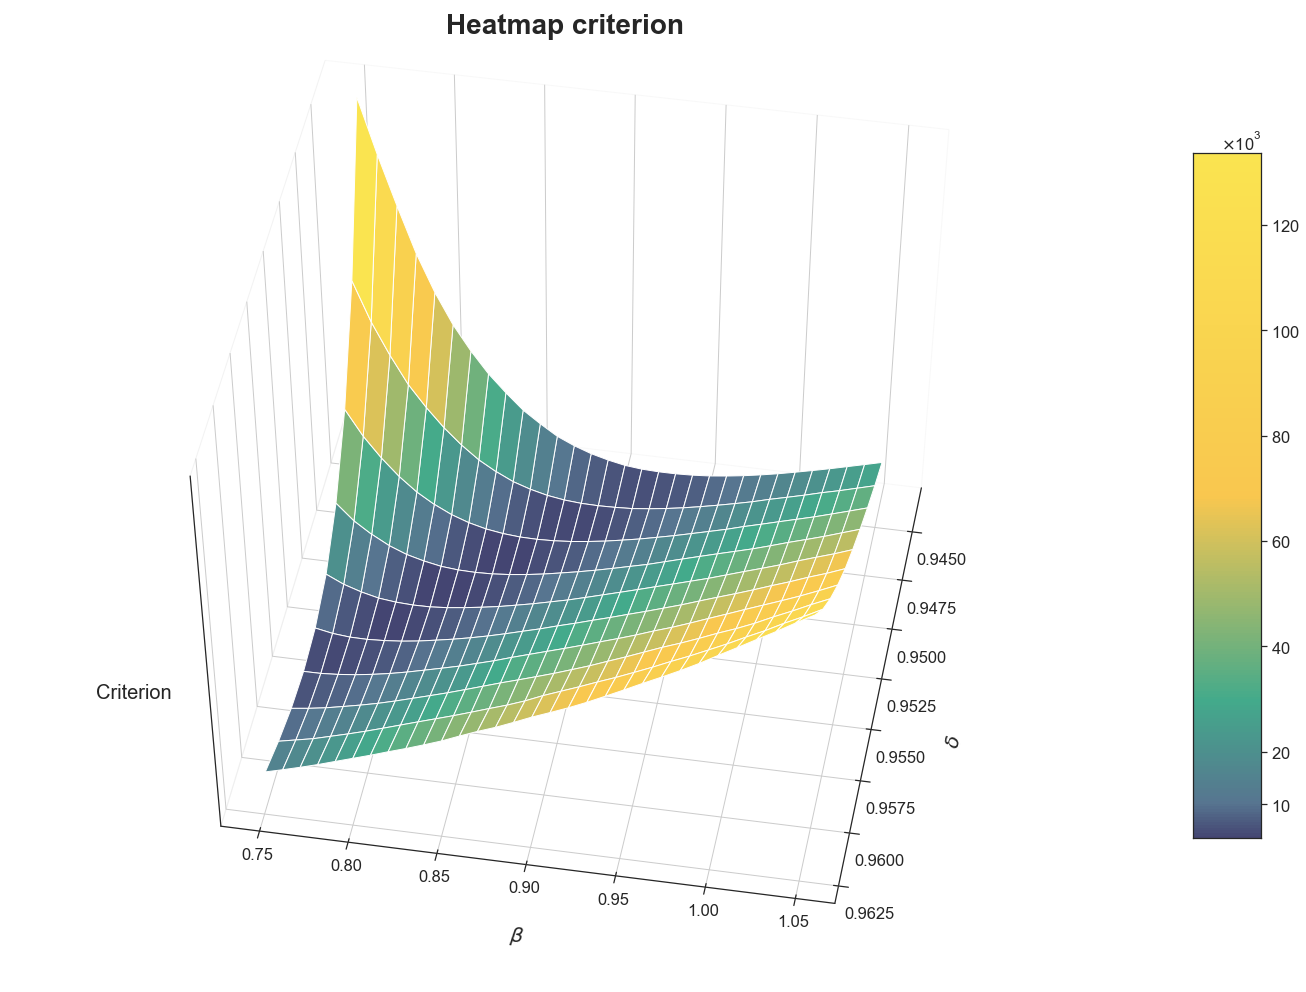

In [6]:
fig = plot_heatmap3d(df_heatmap)

***Notes***: *Evaluations of Method of Simulated Moment’s criterion function for model with hyperbolic discounting
based on Keane and Wolpin (1994), for different value of discount factor and present bias. The candidate structural model with hyperbolic discounting coincides with the true data-generating process of the "observed" dataset. However, the empirical moments do not perfectly coincide with the simulated moments because of random variation in the payoff shocks, which
induces variation in the agents’ choice probabilities. This implies that the criterion function
is not necessarily minimized at the true parameter vector for a given finite sample.*

In the figure above, the darker the area, the lower the value of the criterion function associated with the corresponding combination of $\beta$ and $\delta$. 

A global minimum exists, but there is no basin around it. Instead, the criterion function takes similar values for combinations of the time preference parameters where $\beta$ is underestimated with respect to the true value and $\delta$ is overestimated, and vice versa. This pattern is similar to the "banana-shaped through" found in Abbring et al. (2018) and Laibson et al. (2007), which consider models that are different from the one presented here. 

When $\beta$ is fixed at 1 (corner case of exponential discounting), the criterion function attains the lowest value for a value of the discount factor which lower than the true one. This is consistent with the intuition that a misspecified exponential model fitted on hyperbolic dataset needs a lower discount factor to rationalize the data.

## Counterfactual predictions

The heatmap above points at the practical difficulty of disentangling the time preference parameters in estimation. A relevant question is then whether different combinations of the two parameters produce similar counterfactuals. 

The figure below represents the effect of a 2000 USD tuition subsidy on the experience in education accumulated over the life-cycle, as predicted by the true model and two misspecified models.

In [7]:
with open("data/subsidy_effect.pickle", "rb") as input_file:
    subsidy_effect = pickle.load(input_file)

In [8]:
data = {"true": subsidy_effect["true"], "exponential": subsidy_effect["exp"], "global_min": subsidy_effect["global_min"]}

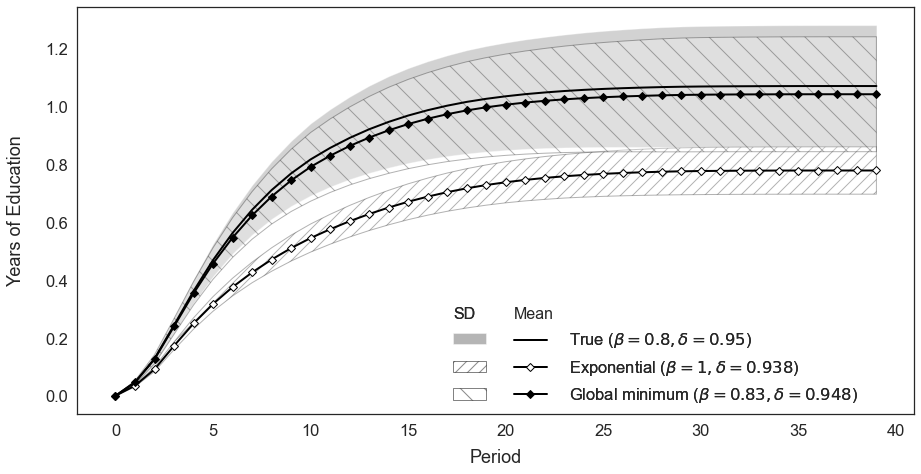

In [9]:
fig = plot_counterfactual_predictions(data, "Experience_Edu", "Years of Education")

***Notes***: *Effect of tuition subsidy of 2000 USD on average years of education in each period, predicted by true
model and misspecified models. The average is computed over 100 datasets with sampling variation, each with 10,000 agents observed for 40 periods. The shaded areas visually represent the simulation error.*

In all models, the tuition subsidy is associated with the largest increase in years of education at the beginning
of the life cycle, and the lowest the discount factor the lowest the average predicted effect in each period. 

The simulation error is largely overlapping whenever the model is hyperbolic, and smaller for the model with exponential discounting. The latter feature can be explained by the decision rule of naïve agents being dynamically inconsistent and
more sensitive to random payoff shocks.

Unsurprisingly, agents react to the introduction of a tuition subsidy and to the introduction of a (deterministic) restriction in their choice set in the same way, that is, spending more time in education. Indeed, a choice restriction raises the option value of education, while the tuition subsidy lowers its per-period cost.

## Bibliography

Abbring, J. H., Daljord, Ø., & Ishakov, F. (2018). Identifying present-biased discount functions
in dynamic discrete choice models.

Keane, M. P., & Wolpin, K. I. (1994). The solution and estimation of discrete choice dynamic
programming models by simulation and interpolation: Monte carlo evidence. *The Review
of Economics and Statistics, 76*(4), 648–672. https://doi.org/10.2307/2109768

Laibson, D. I., Repetto, A.,&Tobacman, J. (2007). Estimating discount functions with consumption
choices over the lifecycle (Working Paper No. 13314). *National Bureau of Economic
Research.* https://doi.org/10.3386/w13314

McFadden, D. (1989). A method of simulated moments for estimation of discrete response models
without numerical integration. *Econometrica, 57*(5), 995–1026. http://www.jstor.org/stable/1913621